In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from control import lqr, dare
from kalman import KalmanFilter
import constants as ct
from parameters import *
from particle3D import Particle

In [2]:
import os 
os.environ["PATH"] += os.pathsep + '/usr/local/bin'
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

In [3]:
elec_xx = 2.83
elec_xy = 2.18
elec_yx = 2.21
elec_yy = 2.36

In [4]:
def compute_phonons(estimations, cov_matrix, step=100):
    sampled_cov_matrix = cov_matrix[::step]
    N = len(sampled_cov_matrix)
    phonons = {'x': np.zeros((N-1)), 'y': np.zeros((N-1)), 'z': np.zeros((N-1))}
    for i in range(1, N):
        averaged = estimations[(i-1)*step:i*step, :].mean(axis=0)
        
        second_moments = sampled_cov_matrix[i]+np.power(averaged,2)
        phonons['x'][i-1] = (second_moments[0,0]+second_moments[3,3])/4-0.5
        phonons['y'][i-1] = (second_moments[1,1]+second_moments[4,4])/4-0.5
        phonons['z'][i-1] = (second_moments[2,2]+second_moments[5,5])/4-0.5

    return phonons

In [5]:
omegas = np.array([2*np.pi*94e3, 2*np.pi*102e3, 2*np.pi*30e3])

B = np.array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [-1, elec_xy/elec_xx, 0],
        [elec_yx/elec_xx, elec_yy/elec_xx, 0],
        [0, 0, 1]])

In [16]:
def create_environment(omegas, B, p, power=300e-3, radius=75e-9, 
                       wavelength=1064e-9, eta_detection=0.34, delta_t=5e-9, 
                       control_step=6, waist=0.6e-6):
    fs = 1/(control_step*delta_t)
    gamma, _, ba_force, std_detection, _ = compute_parameters_simulation(power, wavelength, waist, 
                                                                        radius, p, fs, eta_detection)
    coupling = (1/(4*np.pi))*(ba_force**2)
    env = Particle(omegas, gamma, B, coupling, eta_detection=eta_detection, radius=radius)
    period = 2*np.pi/omegas[2]
    t = np.arange(0, 70 * period, delta_t)
    N = t.shape[0]
    variance_process_x = env.thermal_force_std_x**2 + env.backaction_std_x**2
    variance_process_y = env.thermal_force_std_y**2 + env.backaction_std_y**2
    variance_process_z = env.thermal_force_std_z**2 + env.backaction_std_z**2
    Q = np.array([[0, 0, 0, 0, 0, 0], 
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [0, 0, 0, variance_process_x, 0, 0],
                [0, 0, 0, 0, variance_process_y, 0],
                [0, 0, 0, 0, 0, variance_process_z]])*control_step*delta_t/2
    R = np.array([[3*np.power(std_detection, 2), 0, 0],
                [0, 6*np.power(std_detection, 2), 0],
                [0, 0, np.power(std_detection, 2)]])/2
    Ad = scipy.linalg.expm(env.A *control_step*delta_t)
    Bd = env.B * delta_t * control_step
    g_fb = 100
    Ad = scipy.linalg.expm(env.A *control_step*delta_t)
    Bd = env.B * delta_t * control_step
    cost_states = np.array([[omegas[0]/2, 0, 0, 0, 0, 0],
                            [0, omegas[1]/2, 0, 0, 0, 0],
                            [0, 0, omegas[2]/2, 0, 0, 0],
                            [0, 0, 0, omegas[0]/2, 0, 0],
                            [0, 0, 0, 0, omegas[1]/2, 0],
                            [0, 0, 0, 0, 0, omegas[2]/2]])
    control_effort = np.array([[1/(2*omegas[0]), 0, 0],
                            [0, 1/(2*omegas[1]), 0],
                            [0, 0, 1/(2*omegas[2])]])
    X, L, G = dare(Ad, Bd, cost_states, control_effort/(g_fb))
    return env, Ad, Bd, Q, R, G, control_step, std_detection, t, delta_t, N

In [17]:
def simulate_qparticule3D(omegas, B, p):
    env, Ad, Bd, Q, R, G, control_step, std_detection, t, delta_t, N = create_environment(omegas, B, p)
    x0 = 1000000
    P0 = 100000*np.eye(6)
    estimation = np.zeros((6,1))
    states = x0*np.ones((6,1))
    new_states = np.zeros((N, 6))
    measured_states = np.zeros((N,3))
    estimated_states = np.zeros((N, 6))
    estimated_states[0, :] = estimation[:,0]
    control=np.zeros((3,1))
    controls = np.zeros((3, N))
    kalman = KalmanFilter(-states, P0, Ad, Bd, env.C, Q, R)
    for i in range(t.shape[0]):
        new_states[i, :] = states[:, 0]
        if not i % control_step:
            measurement_noise = np.array(
                [np.sqrt(3)*np.random.normal()*std_detection/env.zp_x,
                np.sqrt(6)*np.random.normal()*std_detection/env.zp_y,
                np.random.normal()*std_detection/env.zp_z]
                )
            measured_states[i,:] = env.C@states[:, 0] + measurement_noise
            kalman.propagate_dynamics(control)
            kalman.compute_aposteriori(measured_states[i].reshape((3,1)))
            estimated_states[i, :] = kalman.estimates_aposteriori[int(i/control_step)][:, 0].reshape((6))
            estimation = estimated_states[i, :].reshape((6, 1))   
            control = -G@estimation
        else:
            measured_states[i] = measured_states[i-1]
            estimated_states[i, :] = estimated_states[i-1,:]
        controls[:,i] = control[:,0]
        states = env.step(states, control=control, delta_t=delta_t)
    phonons = compute_phonons(estimated_states[::control_step, :], kalman.error_covariance_aposteriori, step=300)
    return phonons

In [22]:
pressures = 1e-8
phonons =  simulate_qparticule3D(omegas, B, pressure)
    phonons_x_avg.append(phonons['x'][-10:].mean())
    phonons_x_std.append(phonons['x'][-10:].std())
    phonons_y_avg.append(phonons['y'][-10:].mean())
    phonons_y_std.append(phonons['y'][-10:].std())
    phonons_z_avg.append(phonons['z'][-10:].mean())
    phonons_z_std.append(phonons['z'][-10:].std())

100%|██████████| 10/10 [06:09<00:00, 36.95s/it]


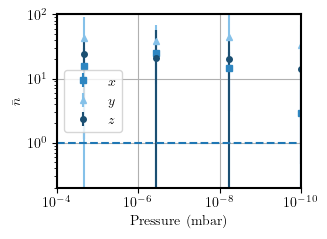

In [23]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']

fig, ax1 = plt.subplots(1, 1)
factor = 0.35
fig.set_size_inches(9*factor, 2.25, forward=True)



ax1.errorbar(pressures[::2]/1e2, phonons_x_avg[::2], yerr=phonons_x_std[::2], fmt='s', label=r'$x$', color=colors[0], markersize=4)
ax1.errorbar(pressures[::2]/1e2, phonons_y_avg[::2], yerr=phonons_y_std[::2], fmt='^', label=r'$y$', color=colors[1], markersize=4)
ax1.errorbar(pressures[::2]/1e2, phonons_z_avg[::2], yerr=phonons_z_std[::2], fmt='o', label=r'$z$', color=colors[2], markersize=4)
ax1.plot([1e-4, 1e-10], [1,1], linestyle='dashed')
ax1.set_xlim([1e-10, 1e-4])
ax1.set_ylim([0.2, 100])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.grid()
#ax1.axvspan(1.4e-2, 2.2e-2, facecolor='0.2', alpha=0.125, zorder=-100)
ax1.invert_xaxis()
ax1.set_xlabel('Pressure (mbar)')
ax1.set_ylabel(r'$\bar{n}$')
#ax1.set_xlim([2.3, 4e-5])
#ax1.set_ylim([0.3, 400])
ax1.legend()
plt.show()